In [1]:
from pyspark.sql.types import *
from pyspark.sql import *
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
from matplotlib import dates as mdates

# Original Data

In [2]:
df=spark.read.csv("online_retail_II.csv", inferSchema=True, header=True)
df.show()
df.count()

+-------+---------+--------------------+--------+-------------------+-----+-----------+--------------+
|Invoice|StockCode|         Description|Quantity|        InvoiceDate|Price|Customer ID|       Country|
+-------+---------+--------------------+--------+-------------------+-----+-----------+--------------+
| 489434|    85048|15CM CHRISTMAS GL...|      12|2009-12-01 07:45:00| 6.95|    13085.0|United Kingdom|
| 489434|   79323P|  PINK CHERRY LIGHTS|      12|2009-12-01 07:45:00| 6.75|    13085.0|United Kingdom|
| 489434|   79323W| WHITE CHERRY LIGHTS|      12|2009-12-01 07:45:00| 6.75|    13085.0|United Kingdom|
| 489434|    22041|"RECORD FRAME 7""...|      48|2009-12-01 07:45:00|  2.1|    13085.0|United Kingdom|
| 489434|    21232|STRAWBERRY CERAMI...|      24|2009-12-01 07:45:00| 1.25|    13085.0|United Kingdom|
| 489434|    22064|PINK DOUGHNUT TRI...|      24|2009-12-01 07:45:00| 1.65|    13085.0|United Kingdom|
| 489434|    21871| SAVE THE PLANET MUG|      24|2009-12-01 07:45:00| 1.2

1067371

In [5]:
df.filter(df.Invoice.startswith("C"))

DataFrame[Invoice: string, StockCode: string, Description: string, Quantity: int, InvoiceDate: timestamp, Price: double, Customer ID: double, Country: string]

In [6]:
df=df.dropna()
df.show()
df.count()

+-------+---------+--------------------+--------+-------------------+-----+-----------+--------------+
|Invoice|StockCode|         Description|Quantity|        InvoiceDate|Price|Customer ID|       Country|
+-------+---------+--------------------+--------+-------------------+-----+-----------+--------------+
| 489434|    85048|15CM CHRISTMAS GL...|      12|2009-12-01 07:45:00| 6.95|    13085.0|United Kingdom|
| 489434|   79323P|  PINK CHERRY LIGHTS|      12|2009-12-01 07:45:00| 6.75|    13085.0|United Kingdom|
| 489434|   79323W| WHITE CHERRY LIGHTS|      12|2009-12-01 07:45:00| 6.75|    13085.0|United Kingdom|
| 489434|    22041|"RECORD FRAME 7""...|      48|2009-12-01 07:45:00|  2.1|    13085.0|United Kingdom|
| 489434|    21232|STRAWBERRY CERAMI...|      24|2009-12-01 07:45:00| 1.25|    13085.0|United Kingdom|
| 489434|    22064|PINK DOUGHNUT TRI...|      24|2009-12-01 07:45:00| 1.65|    13085.0|United Kingdom|
| 489434|    21871| SAVE THE PLANET MUG|      24|2009-12-01 07:45:00| 1.2

824364

### Canceled Orders


In [7]:
c_orders=df.filter(df.Invoice.startswith("C"))
c_orders.show()

+-------+---------+--------------------+--------+-------------------+-----+-----------+--------------+
|Invoice|StockCode|         Description|Quantity|        InvoiceDate|Price|Customer ID|       Country|
+-------+---------+--------------------+--------+-------------------+-----+-----------+--------------+
|C489449|    22087|PAPER BUNTING WHI...|     -12|2009-12-01 10:33:00| 2.95|    16321.0|     Australia|
|C489449|   85206A|CREAM FELT EASTER...|      -6|2009-12-01 10:33:00| 1.65|    16321.0|     Australia|
|C489449|    21895|POTTING SHED SOW ...|      -4|2009-12-01 10:33:00| 4.25|    16321.0|     Australia|
|C489449|    21896|  POTTING SHED TWINE|      -6|2009-12-01 10:33:00|  2.1|    16321.0|     Australia|
|C489449|    22083|PAPER CHAIN KIT R...|     -12|2009-12-01 10:33:00| 2.95|    16321.0|     Australia|
|C489449|    21871| SAVE THE PLANET MUG|     -12|2009-12-01 10:33:00| 1.25|    16321.0|     Australia|
|C489449|    84946|ANTIQUE SILVER TE...|     -12|2009-12-01 10:33:00| 1.2

### Successful Orders

In [8]:
s_orders=df.filter(df.Quantity > 0)
s_orders=s_orders.withColumn("sales",s_orders["Quantity"]*s_orders["Price"])
s_orders.show()

+-------+---------+--------------------+--------+-------------------+-----+-----------+--------------+------------------+
|Invoice|StockCode|         Description|Quantity|        InvoiceDate|Price|Customer ID|       Country|             sales|
+-------+---------+--------------------+--------+-------------------+-----+-----------+--------------+------------------+
| 489434|    85048|15CM CHRISTMAS GL...|      12|2009-12-01 07:45:00| 6.95|    13085.0|United Kingdom|              83.4|
| 489434|   79323P|  PINK CHERRY LIGHTS|      12|2009-12-01 07:45:00| 6.75|    13085.0|United Kingdom|              81.0|
| 489434|   79323W| WHITE CHERRY LIGHTS|      12|2009-12-01 07:45:00| 6.75|    13085.0|United Kingdom|              81.0|
| 489434|    22041|"RECORD FRAME 7""...|      48|2009-12-01 07:45:00|  2.1|    13085.0|United Kingdom|100.80000000000001|
| 489434|    21232|STRAWBERRY CERAMI...|      24|2009-12-01 07:45:00| 1.25|    13085.0|United Kingdom|              30.0|
| 489434|    22064|PINK 

####  1- Most Sold Product


In [9]:
msp=df.select(df["Description"],df["Quantity"]).groupBy(df["Description"]).sum()
msp=msp.withColumnRenamed("sum(Quantity)", "sold")
topten=msp.orderBy(msp.sold, ascending=0).limit(20)
topten.show()

+--------------------+------+
|         Description|  sold|
+--------------------+------+
|WORLD WAR 2 GLIDE...|107489|
|WHITE HANGING HEA...| 90008|
|ASSORTED COLOUR B...| 79434|
|JUMBO BAG RED RET...| 74564|
| BROCADE RING PURSE | 70390|
|PACK OF 60 PINK P...| 55051|
|60 TEATIME FAIRY ...| 53169|
|PACK OF 72 RETROS...| 45742|
|PACK OF 72 RETRO ...| 44507|
|SMALL POPCORN HOLDER| 43602|
|MINI PAINT SET VI...| 43340|
|ASSORTED COLOURS ...| 40161|
|COLOUR GLASS T-LI...| 38921|
|PACK OF 72 SKULL ...| 38838|
|PACK OF 12 LONDON...| 38012|
|VICTORIAN GLASS H...| 36842|
|RED  HARMONICA IN...| 36217|
|JUMBO BAG STRAWBERRY| 35815|
|72 SWEETHEART FAI...| 34131|
|STRAWBERRY CERAMI...| 33798|
+--------------------+------+



In [10]:
#prdct=topten.select("Description")
#pprc=s_orders.select("Description","Price")

#poverp=pprc.join(prdct,on=['Description'], how='inner')
#poverp.distinct().show()#

In [11]:
prod=topten.rdd.map(lambda x: x[0]).collect()
nsold=topten.rdd.map(lambda x: x[1]).collect()

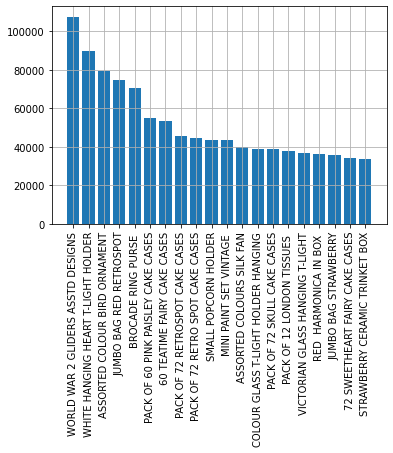

In [12]:
plt.bar(prod,nsold)
plt.xticks(prod, rotation="vertical")
plt.grid(1)
plt.show()

#### 2- Sales Overtime


In [13]:
m=s_orders.rdd.map(lambda x: ((x[4].year, x[4].month),x[0]))


In [14]:
columns= m.map(lambda r: Row(Month= r[0], Invoice= r[1]))
mdf= spark.createDataFrame(columns)
#mdf.dropDuplicates(['Month', 'Invoice']).filter(mdf.Invoice=='489434').show()
mdf=mdf.distinct().groupBy(mdf["Month"]).count().orderBy("Month")

In [15]:
months=mdf.rdd.map(lambda x: x[0]).collect()
sales=mdf.rdd.map(lambda x: x[1]).collect()


In [86]:
dt=s_orders.rdd.map(lambda x: (datetime.strptime(str(x[4])[:10],"%Y-%m-%d") ,x[8])).reduceByKey(lambda x,y:x+y).sortBy(lambda x: x[0])

[(datetime.datetime(2009, 12, 1, 0, 0), 44048.69000000008),
 (datetime.datetime(2009, 12, 2, 0, 0), 52941.989999999736),
 (datetime.datetime(2009, 12, 3, 0, 0), 67479.07999999971),
 (datetime.datetime(2009, 12, 4, 0, 0), 34064.4100000001),
 (datetime.datetime(2009, 12, 5, 0, 0), 9803.050000000001)]

In [87]:
dates=dt.map(lambda x: x[0]).collect()

sl=dt.map(lambda x: x[1]).collect()


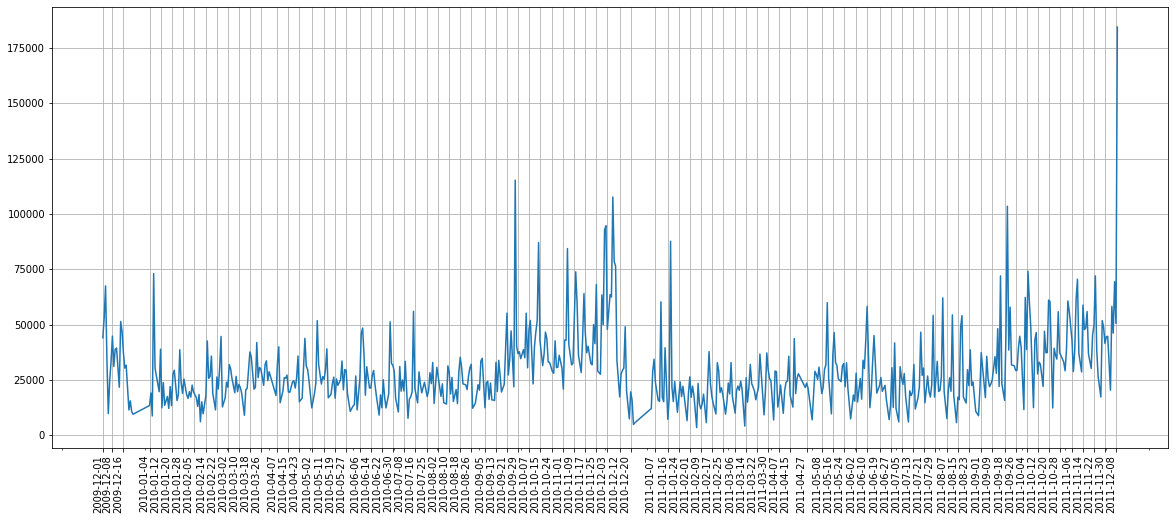

In [106]:
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y-%m-%d')

fig, ax = plt.subplots()
ax.plot(dates,sl)
fig.set_size_inches(20, 9)
# format the ticks
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)
plt.grid(True)
fig.autofmt_xdate()
plt.xticks(dates[::7],rotation="vertical")
plt.show()

#### 3 - Sales Per Month

In [39]:
spm=s_orders.rdd.map(lambda x:(datetime.strftime(x[4],"%B,%Y") ,x[8])).reduceByKey(lambda x,y: x+y)
spm.collect()

[('May,2010', 599985.7900000075),
 ('June,2010', 639066.5800000058),
 ('July,2010', 591636.7400000109),
 ('December,2010', 884591.8899999922),
 ('April,2011', 469200.3610000132),
 ('May,2011', 678594.5600000018),
 ('June,2011', 661213.6900000115),
 ('July,2011', 600091.0110000141),
 ('January,2010', 557319.0620000134),
 ('August,2010', 604242.6499999989),
 ('February,2011', 447137.3500000165),
 ('August,2011', 645343.9000000092),
 ('September,2011', 952838.3819999965),
 ('November,2011', 1161817.3799999433),
 ('December,2011', 518210.7900000037),
 ('December,2009', 686654.1599999949),
 ('February,2010', 506371.06600001536),
 ('April,2010', 594609.1919999976),
 ('September,2010', 831615.0009999905),
 ('November,2010', 1172336.0419998672),
 ('March,2010', 699608.9909999889),
 ('October,2010', 1036679.9999999028),
 ('January,2011', 569445.0400000077),
 ('March,2011', 595500.760000013),
 ('October,2011', 1039318.7899999822)]

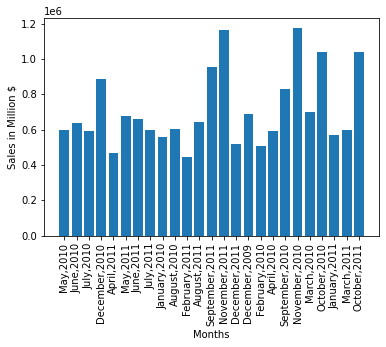

In [41]:
ms=spm.map(lambda x: x[0]).collect()
slv=spm.map(lambda x: x[1]).collect()
plt.bar(ms,slv)
plt.xticks(ms,rotation="vertical")
plt.xlabel("Months")
plt.ylabel("Sales in Million $")
plt.show()

#### 4 - What time is best for advertisement

In [15]:
bat=df.select(df["InvoiceDate"], df["Invoice"]).distinct()
x=bat.rdd.map(lambda x: (int(x[0].hour), x[1]))
bat=x.map(lambda r: Row(Hour= r[0], Invoice= r[1]))
bt=spark.createDataFrame(bat)
adt=bt.groupBy(bt.Hour).count().orderBy("Hour")

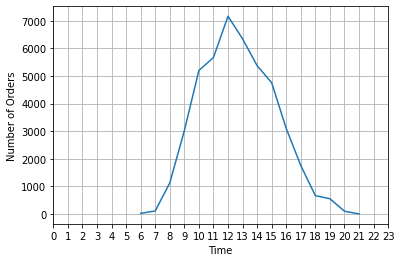

In [16]:
time=adt.select("Hour").collect()
count=adt.select("count").collect()
plt.plot(time,count)
plt.grid(True)
plt.xlabel("Time")
plt.ylabel("Number of Orders")
plt.xticks(range(0,24))
plt.show()

### 4- Price Histogram


In [149]:
prices= df.select("StockCode", df["Price"].cast("double")).groupBy("Price").count()
prices.orderBy("count", ascending=False).show()

+-----+-----+
|Price|count|
+-----+-----+
| 1.25|99565|
| 1.65|72549|
| 2.95|64509|
| 0.85|62315|
| 0.42|42600|
|  2.1|41765|
| 3.75|39316|
| 4.95|34588|
| 1.95|33417|
| 2.55|31238|
| 1.45|23878|
| 5.95|19186|
| 0.55|16758|
| 4.25|16009|
| 2.08|15945|
| 0.65|15932|
| 7.95|14450|
|  8.5|12009|
| 9.95|11973|
| 1.69|10063|
+-----+-----+
only showing top 20 rows



In [ ]:
pr=prices.rdd.map(lambda x: x[0]).collect()
n=prices.rdd.map(lambda x: x[1]).collect()

(array([225.,  57.,   8.,   4.]),
 array([   100,   1000,   5000,  10000, 100000]),
 <a list of 4 Patch objects>)

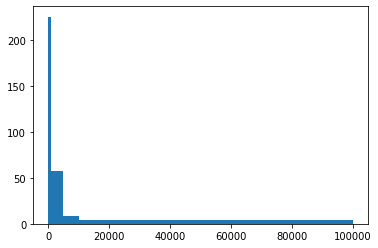

In [161]:
bins=[100,1000,5000,10000,100000]
plt.hist(pr,bins=bins)

### 5- day with most orders

In [1]:
dwmo=s_orders.rdd.map(lambda x: ((x[4].weekday(),x[4].strftime("%A")),1)).reduceByKey(lambda x,y: x+y).sortBy(lambda x:x[0][0])
dmwo.show()

NameError: name 's_orders' is not defined

In [182]:
day=dwmo.map(lambda x: x[0][1]).collect()
values=dwmo.map(lambda x:x[1]).collect()

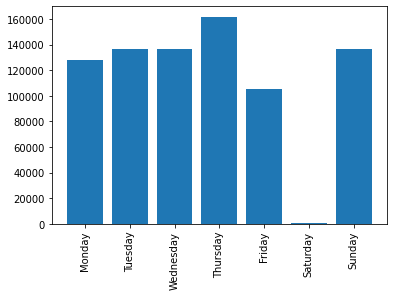

In [206]:
plt.bar(day, values)
plt.xticks(day, rotation="vertical")
plt.show()

### 6- Top 10 Customers

In [207]:
bestc=s_orders.select("Invoice","Customer ID").distinct()
bestc=bestc.rdd.map(lambda x:(int(x[1]),1)).reduceByKey(lambda x,y: x+y).sortBy(lambda x: x[1],False)
bestc=bestc.map(lambda r: Row(cID= r[0], nOrders= r[1]))
bestc=spark.createDataFrame(bestc)
bestc=bestc.limit(20)
bestc.show()

+-----+-------+
|  cID|nOrders|
+-----+-------+
|14911|    398|
|12748|    337|
|17841|    211|
|15311|    208|
|13089|    203|
|14606|    192|
|14156|    156|
|17850|    155|
|14646|    152|
|18102|    145|
|13694|    143|
|15061|    127|
|14527|    122|
|17949|    118|
|12971|    116|
|13798|    110|
|16422|    109|
|16029|    107|
|13408|    106|
|17961|    100|
+-----+-------+



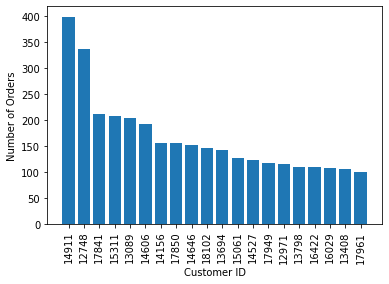

In [208]:
cID=bestc.rdd.map(lambda x: str(x[0])).collect()
nOrders=bestc.rdd.map(lambda x: x[1]).collect()
plt.bar(cID,nOrders)
plt.xticks(cID,rotation="vertical")
plt.xlabel("Customer ID")
plt.ylabel("Number of Orders")
plt.show()